# Luminance Normalization

You will need to install some packages. This can all be installed via pip.

You will need:

* opencv-python-nonfree
* numpy
* scipy
* matplotlib
* ipykernel 

In [1]:
import cv2
import numpy as np
import scipy.special
import scipy.stats
from IPython.display import Image
from matplotlib import pyplot as plt

***Scroll down past all these functions to get to the meat.***

In [2]:
# *******************************************************************************************************************
def clip_LAB(img, chan):
    
    if chan == 0:
        img[:,:,0]  = np.clip(img[:,:,0], 0.0, 100.0)       # L ranges from 0 to 100
    elif chan == 1:
        img[:,:,1]  = np.clip(img[:,:,1], -127.0, 127.0)    # a ranges from -127 to 127
    elif chan == 2:       
        img[:,:,2]  = np.clip(img[:,:,2], -127.0, 127.0)    # b ranges from -127 to 127
        
    return img

In [3]:
# *******************************************************************************************************************
def show_hist(img, file_name=None):
    '''
    Create histogram of pixel values and display.
    '''
    
    hist, bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    plt.plot(cdf_normalized, color = 'b')
    plt.hist(img.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    
    if file_name is not None:
        plt.savefig(file_name)
    
    plt.show()
    


In [4]:
# *******************************************************************************************************************
def contrast_adjust(img, chan=0, val=1.0):
    '''
    Basic contrast adjustment function
    
    Center the image at 0 by subtracting the mean. Then multiply by a number. If the number is
    greater than 1.0 then we increase contrast. If it is less then 1.0 then we decrease contrast. 
    
    We need to clip values since they can run past the pixel value limit. 
    
    '''
    
    fimg            = img.astype(np.float32) / 255.0
    nimg            = cv2.cvtColor(fimg,  cv2.COLOR_BGR2LAB)
    
    mean,_          = cv2.meanStdDev(nimg[:,:,chan])
    nimg[:,:,chan]  = (nimg[:,:,chan] - mean) * val + mean
    nimg            = clip_LAB(nimg, chan)
    
    rimg            = (cv2.cvtColor(nimg,  cv2.COLOR_LAB2BGR)*255.0).astype(np.uint8)  
    
    return rimg

In [5]:
# *******************************************************************************************************************
def cdf_normalize(img,breadth=1.0):

    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    L = lab_img[:,:,0]
    
    m = np.mean(L)
    s = np.std(L)*breadth
    
    L = 0.5*(1.0 + scipy.special.erf((L-m)/(s*np.sqrt(2.0))))
    
    lab_img[:,:,0] = L*255.0
    
    return cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)

In [6]:
# *******************************************************************************************************************
def _k_update(k,s):

    nm = np.log(k) - scipy.special.digamma(k) - s
    dn = np.reciprocal(k) - scipy.special.polygamma(1,k)
    k2 = k - nm/dn

    return k2

In [7]:
# *******************************************************************************************************************    
def _compute_k_est(x, i=10):
    '''
    Estimate the shape parameter k. 
    
    The Gamma probability distribution requires two parameters: shape and scale. Shape can be thought of as
    a kind of log variance. 
    
    Estimation of s for the first line is most of the time complexity. Since s is a single number, 
    the refinement steps afterwards are not very expensive. 
    '''
    
    # avoid log(0)
    x  = x + 0.0000001

    #Calculate s (a single value)
    s  = np.log(np.mean(x)) - np.mean(np.log(x))

    # Get estimate of k to within 1.5%
    #
    # NOTE: K gets smaller as log variance s increases
    #
    s3 = s - 3.0
    rt = np.sqrt(np.power(s3,2) + 24.0 * s)
    nm = 3.0 - s + rt
    dn = 12.0 * s
    k  = nm / dn + 0.0000001

    # Do i Newton-Raphson steps to get closer than 1.5%
    # For i=5 gets us within 4 or 5 decimal places
    for _ in range(i):
        k =  _k_update(k,s)

    return k

In [8]:
# *******************************************************************************************************************
def cdf_gamma_normalize(img):
    '''
    Gamma probability based normalization:
    
    https://en.wikipedia.org/wiki/Gamma_distribution
    
    This works well if we have a preponderance of dark pixels with fewer light pixels.  
    
    Note: all pixels must have a positive real value. 
    '''

    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    L = lab_img[:,:,0]
    
    # Get the shape parameter
    shape = _compute_k_est(L)
    
    # Scale acts very much like an estimate of conditional information
    scale = np.reciprocal(shape) * np.mean(L)
    
    L = scipy.stats.gamma.cdf(L, a=shape, scale=scale)
    
    lab_img[:,:,0] = L*255.0
    
    return cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)
    

In [9]:
# *******************************************************************************************************************
def cdf_beta_normalize(img):
    '''
    Beta probability based normalization:
    
    https://en.wikipedia.org/wiki/Beta_distribution
    
    This works well so long as values are bound between 0 and 1. So we can apply it to almost any image 
    which we have just loaded since the values will be already bound (e.g. 0 to 255). This function assumes
    the image is in the range of 0 to 255 and will divide it for you. 
    '''
    
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    L = lab_img[:,:,0]/255.0
    
    # a and b parameters can be estimated from the mean and variance.
    m = np.mean(L)
    s = np.var(L,ddof=1)
    
    v = (m*(1.0 - m))/s - 1.0
    
    a = m*v
    b = (1.0 - m)*v
    
    L = scipy.special.betainc(a,b,L) # Scipy mislabled this, it is actually the *regularized* incomplete beta function

    lab_img[:,:,0] = L*255.0
    
    return cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)

In [10]:
# *******************************************************************************************************************
def range_normalize(img):

    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    L = lab_img[:,:,0]
    
    Lmax = np.max(L)
    Lmin = np.min(L)
    
    range = Lmax - Lmin
    
    if range != 0:
        L = (L - Lmin)/range
    
    lab_img[:,:,0] = L*255.0
    
    return cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)

In [11]:
# *******************************************************************************************************************
def log_normalize(img):

    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    L = lab_img[:,:,0] + 1.0
    
    L = np.log2(L)
    
    lab_img[:,:,0] = L*(255.0/8.0)
    
    return cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)

In [12]:
# *******************************************************************************************************************
def histogram_normalize(img):

    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    L = lab_img[:,:,0]

    L = cv2.equalizeHist(L)

    lab_img[:,:,0] = L
    
    return cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)

In [13]:
# *******************************************************************************************************************
def adaptive_hist_normalize(img):

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  
    
    L = lab_img[:,:,0]
    
    L = clahe.apply(L)
    
    lab_img[:,:,0] = L
    
    return cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)


## Select the image

The variable "input_image_name" needs to be an image relative to your working directory.  

In [14]:
'''
Feedstock images
'''
input_image_name    = "Tile_r4-c19_Acquisition_Spec_8_1148244855.jpg" # LOT AO BEFORE PROJECTOR FILAMENT REPLACEMENT
#input_image_name    = "Tile_r4-c19_Acquisition_Spec_9_1931512394.jpg" # LOT D BEFORE PROJECTOR FILAMENT REPLACEMENT
#input_image_name    = "Tile_r4-c18_Region2_1071224939.jpg" # LOT AO AFTER PROJECTOR FILAMENT REPLACEMENT
#input_image_name    = "Tile_r5-c7_Region1_692733358.jpg"  # LOT D AFTER PROJECTOR FILAMENT REPLACEMENT

'''
Natural images
'''
#input_image_name    = "ILSVRC2012_val_00049934.224x224.png
#input_image_name    = "ILSVRC2012_val_00049931.JPEG"
# input_image_name    = "IMG_1382.jpg"
#input_image_name    = "IMG_2730.jpg"

'''
NIF images (good for showing issues with histogram normalization)
'''
#input_image_name    = "OMF2_715165_45723294_POST_144_306_EXIT_RB_191024_174606.tif"
#input_image_name    = "OMF2_715165_45972761_POST_160_267_EXIT_RB_191025_072939.tif" ## Example A
#input_image_name    = "OMF2_715165_47391944_POST_85_273_EXIT_RB_191024_203453.tif"
#input_image_name    = "OMF2_715165_48284471_POST_362_243_EXIT_RB_191024_204748.tif"
#input_image_name    = "OMF2_715165_48286090_POST_105_340_EXIT_RB_191024_220021.tif" ## Example B

save_prefix         = input_image_name[:-4]

# For NIF TIFs
img = cv2.imread(input_image_name)
_ = cv2.imwrite("{}.jpeg".format(save_prefix),img)

## Raw image and Histogram of Pixel Values

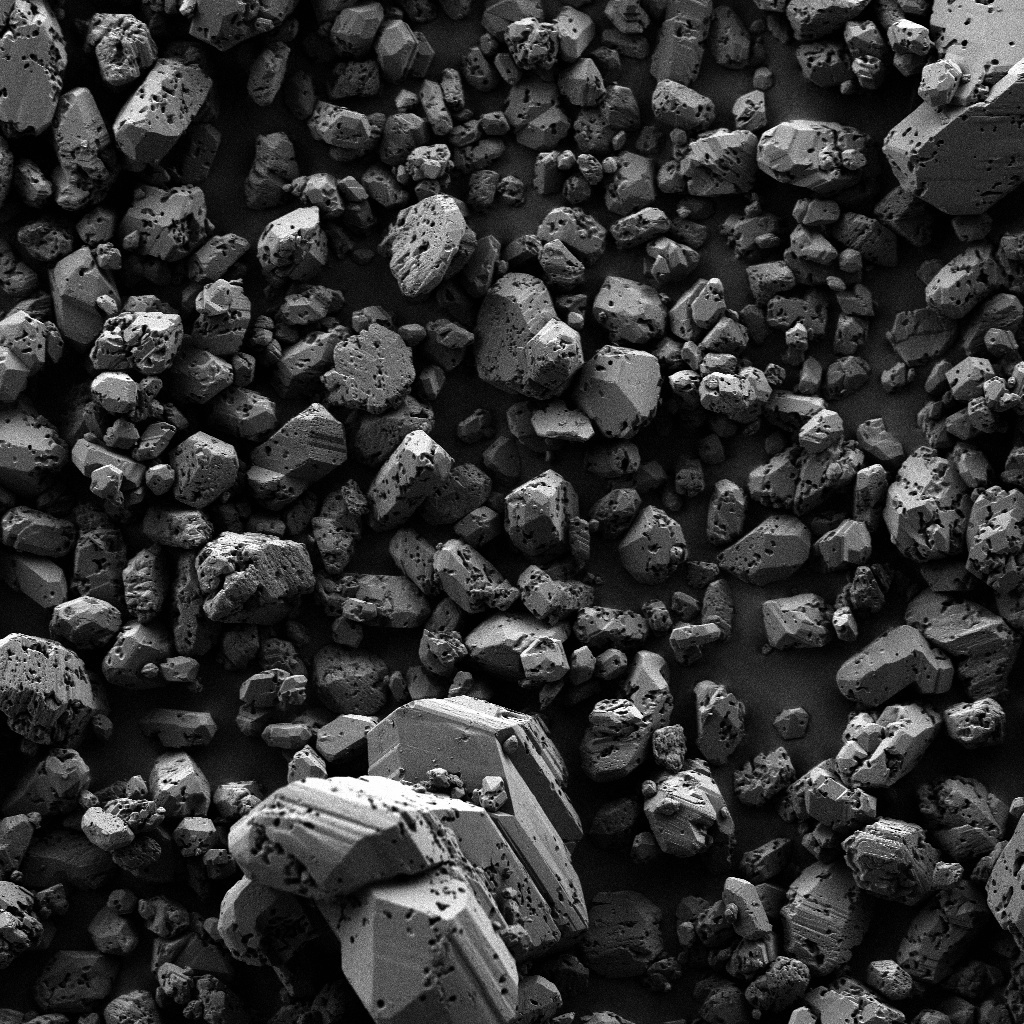

In [15]:
Image(filename="{}.jpeg".format(save_prefix))

In [16]:
img = cv2.imread(input_image_name)

If the image is ideal, then the blue line should be smooth and diagonal. That means pixel values are uniformly distributed.   

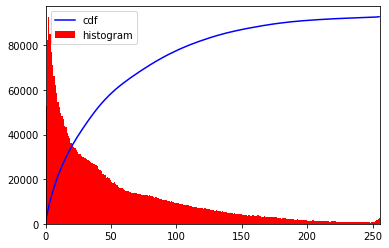

In [17]:
show_hist(img, file_name="{}.HIST.original.png".format(save_prefix))

## Normalization with a Normal (Gaussian) CDF

Here we just estimate mean and standard dev. and then apply the cumulative distribution function to squash the values.

https://en.wikipedia.org/wiki/Normal_distribution

In [18]:
norm_img = cdf_normalize(img,breadth=1.0)

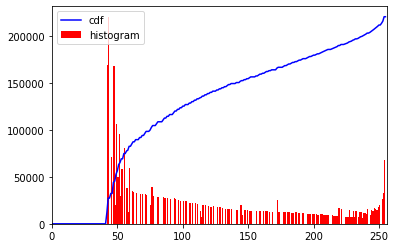

In [19]:
show_hist(norm_img,file_name="{}.HIST.norm.png".format(save_prefix))

In [20]:
_ = cv2.imwrite("{}.norm_img_LAB.jpg".format(save_prefix),norm_img)

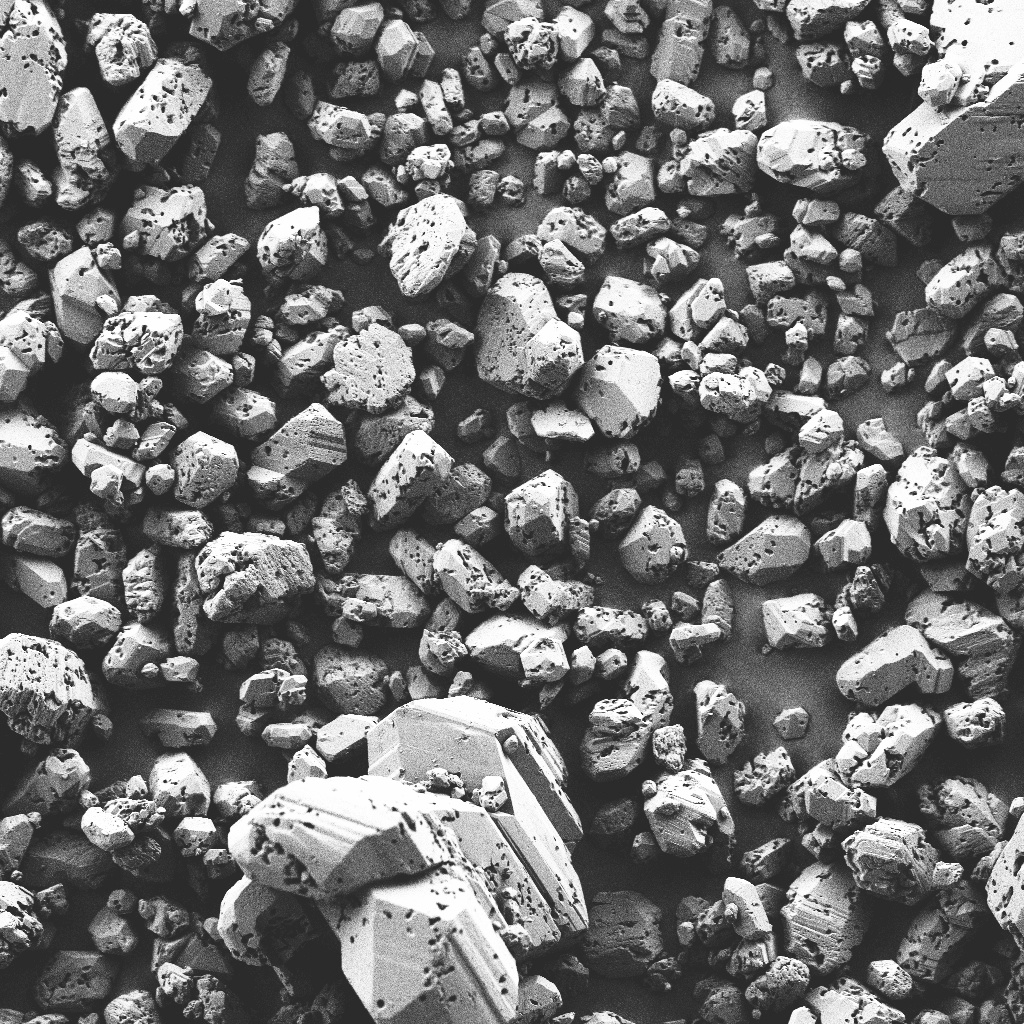

In [21]:
Image(filename="{}.norm_img_LAB.jpg".format(save_prefix))

## Normalization with a Gamma CDF
Here we just estimate scale and shape parematers and then apply the cumulative distribution function to squash the values. This assumes an exponential distribution where we have lots of dark pixels and very few light pixels. 

https://en.wikipedia.org/wiki/Gamma_distribution

See more examples and explanation:

https://myconfluence.llnl.gov/display/FeedOpt/Light+Intensity+has+a+Gamma+Probability+Distribution

In [22]:
gamma_img = cdf_gamma_normalize(img)

For Feedstock SEM images, the blue line is mostly diagonal. This means that the image is fairly normalized. The advantage of this method is that it is linear and well behaved. 

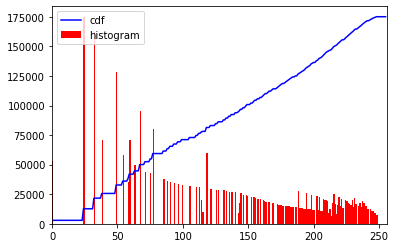

In [23]:
show_hist(gamma_img,file_name="{}.HIST.gamma.png".format(save_prefix))

In [24]:
_ = cv2.imwrite("{}.gamma_img.jpg".format(save_prefix),gamma_img)

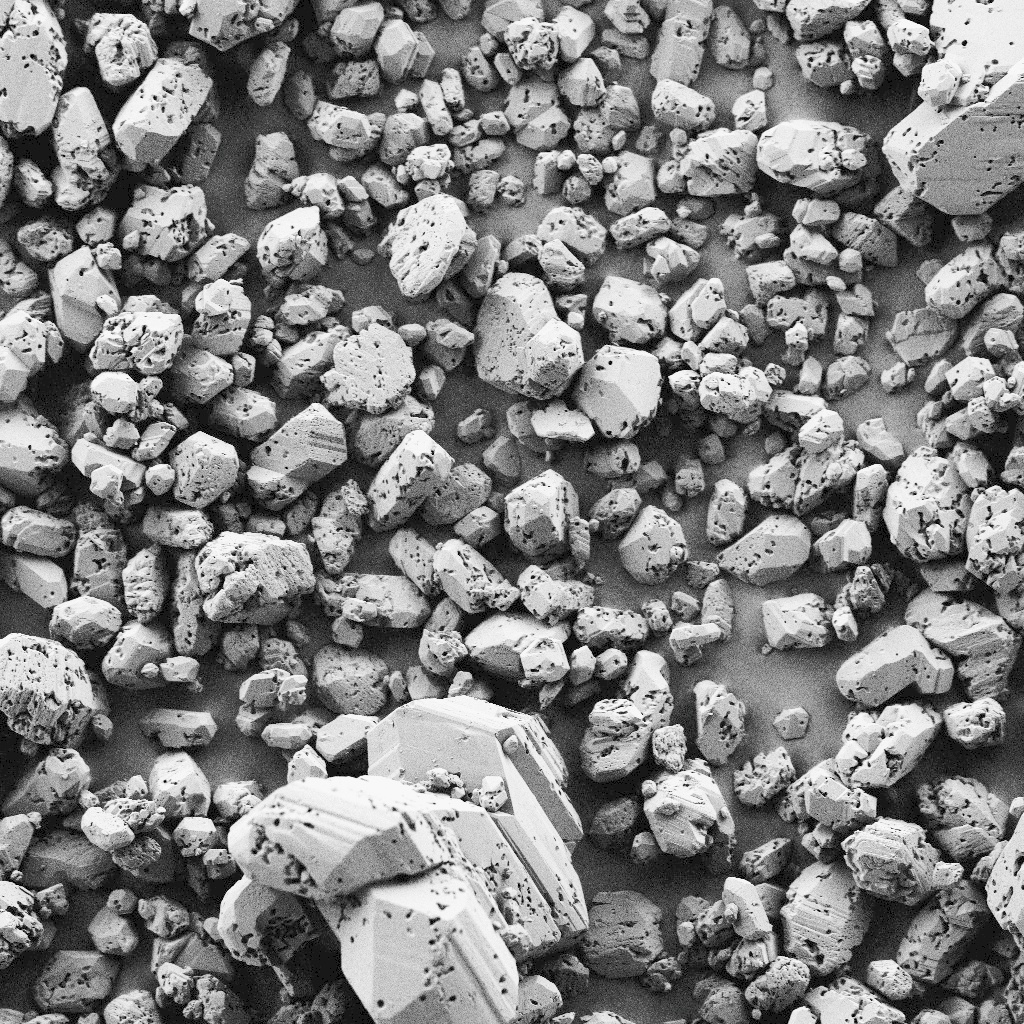

In [25]:
Image(filename="{}.gamma_img.jpg".format(save_prefix))

## Normalization with a Beta CDF
Assumes we have values bounded between 0 and 1. It is highly flexable for distributions within this range and can even fit bi-modal data. 

https://en.wikipedia.org/wiki/Beta_distribution


In [48]:
beta_img = cdf_beta_normalize(img)

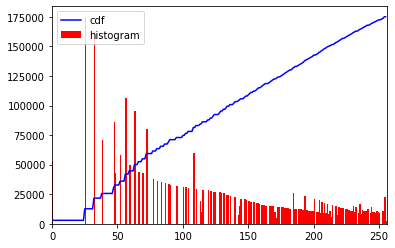

In [54]:
show_hist(beta_img,file_name="{}.HIST.beta.png".format(save_prefix))

In [55]:
_ = cv2.imwrite("{}.beta_img.jpg".format(save_prefix),beta_img)

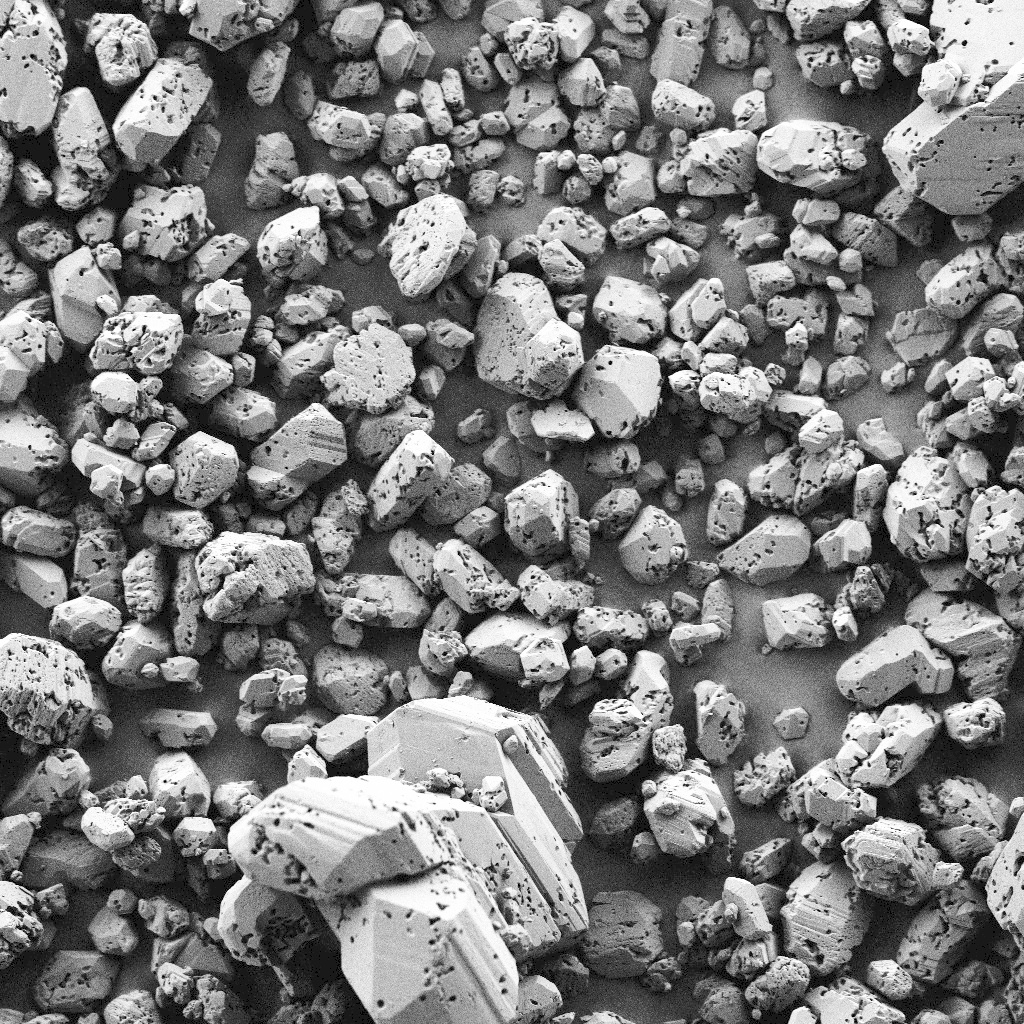

In [56]:
Image(filename="{}.beta_img.jpg".format(save_prefix))

## Try adding is some contrast enhancement

In [57]:
img_high = contrast_adjust(img, chan=0, val=1.25)

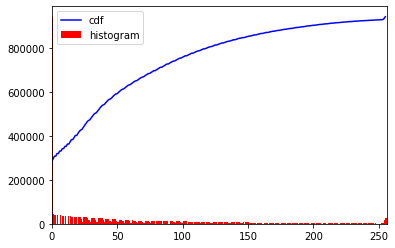

In [59]:
show_hist(img_high,file_name="{}.HIST.cont_norm.png".format(save_prefix))

In [60]:
_ = cv2.imwrite("{}.cont_norm_img.jpg".format(save_prefix),img_high)

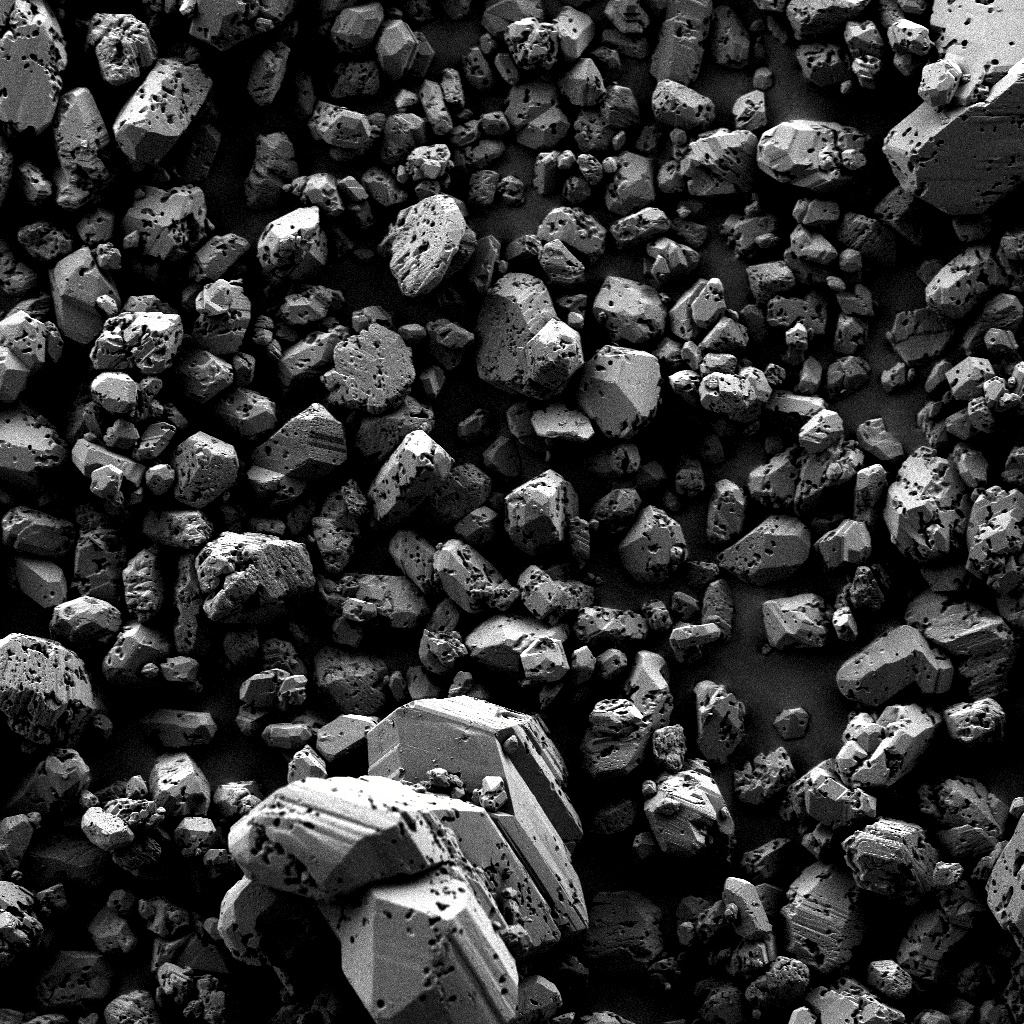

In [26]:
Image(filename="{}.cont_norm_img.jpg".format(save_prefix))

## Histogram Normalization
Violently force the pixel values in an image to be uniformly distributed. This has pathological cases where it can really mess things up. 

https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html

In [62]:
equ_img = histogram_normalize(img)

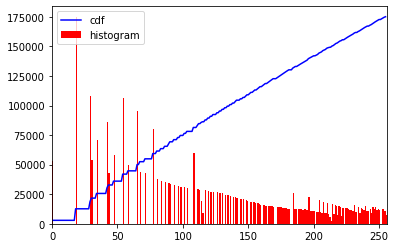

In [63]:
show_hist(equ_img,file_name="{}.HIST.histogram_equ.png".format(save_prefix))

In [64]:
_ = cv2.imwrite("{}.histogram_equ_img.jpg".format(save_prefix),equ_img)

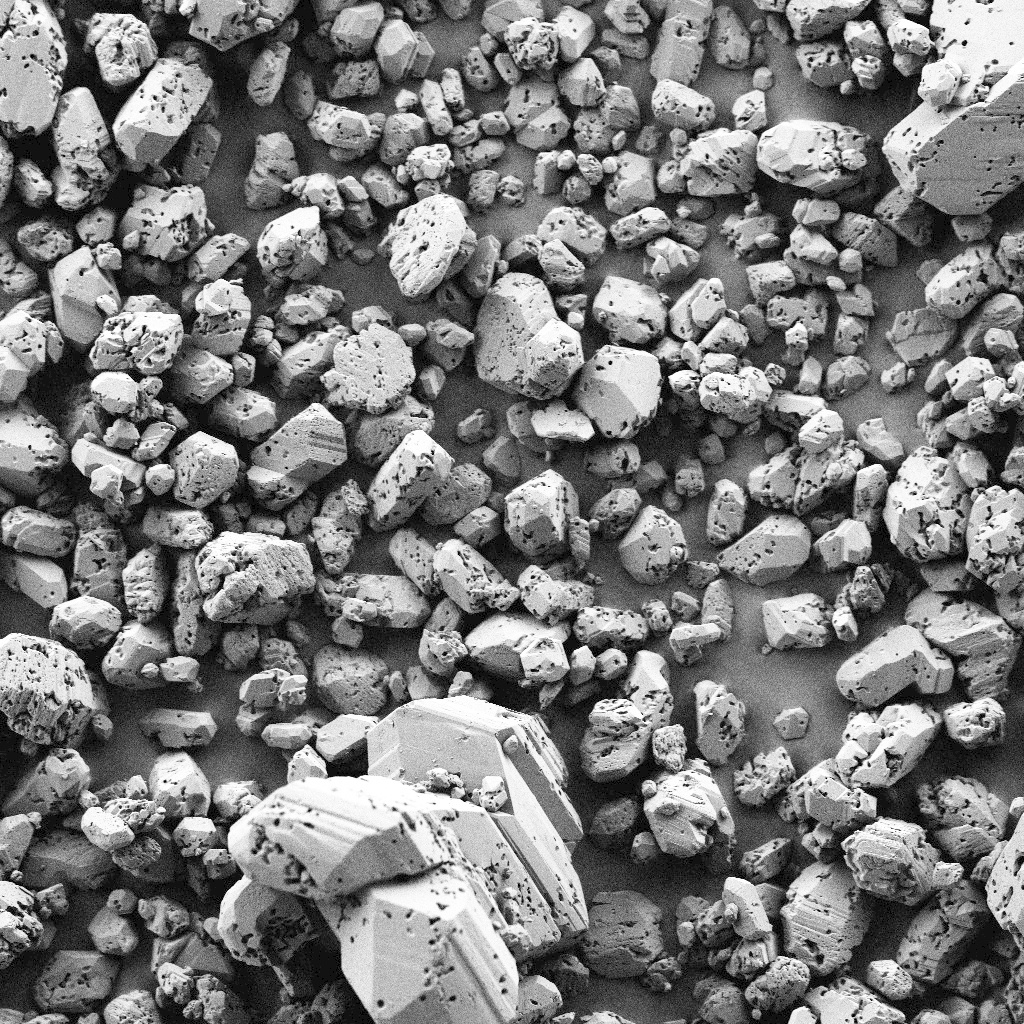

In [65]:
Image(filename="{}.histogram_equ_img.jpg".format(save_prefix))

## Adaptive Histogram Normalization
Try to force the pixel values in an image to be uniformly distributed. This is much better behaved than the non-adptive method, but is fairly non-linear. 

In [66]:
cl1_img = adaptive_hist_normalize(img)

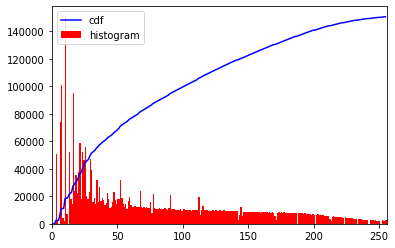

In [68]:
show_hist(cl1_img,file_name="{}.HIST.adapt_equ.png".format(save_prefix))

In [69]:
_ = cv2.imwrite("{}.adapt_equ_img.jpg".format(save_prefix),cl1_img)

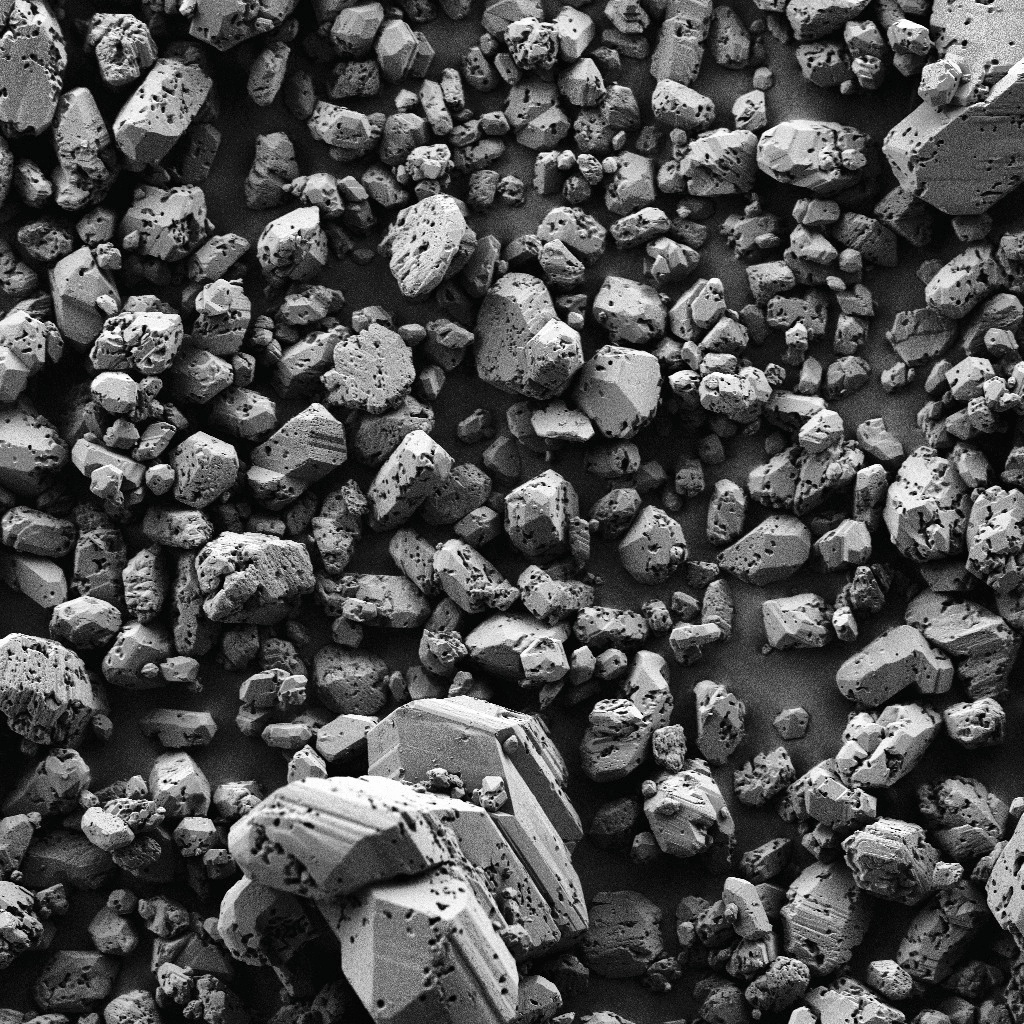

In [70]:
Image(filename="{}.adapt_equ_img.jpg".format(save_prefix))

# License

BSD 3-Clause License

Copyright (c) 2021, Lawrence Livermore National Security, LLC
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

LLNL-CODE-818824